In [1]:
import numpy as np
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pyshark

In [2]:
# detecting movement within each video
def quantify_motion_frame_differencing(video_path, threshold=25, blur_kernel_size=(5, 5)):
    """
    Quantifies movement in an MP4 video using frame differencing.

    Args:
        video_path (str): Path to the input MP4 video file.
        threshold (int): Pixel intensity difference threshold. Pixels with a
                         difference greater than this are considered motion.
                         (0-255).
        blur_kernel_size (tuple): Kernel size for Gaussian blur applied to
                                  frames before differencing to reduce noise.

    Returns:
        tuple: A tuple containing:
            - list: A list of motion scores (number of moving pixels) for each frame.
            - int: The total number of frames processed.
            - float: The original video's FPS.
    """

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return [], 0, 0.0

    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        return [], 0, 0.0

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Processing video: {video_path}")
    print(f"FPS: {fps}")
    print(f"Total frames: {total_frames}")

    # Convert the first frame to grayscale and apply blur
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_gray = cv2.GaussianBlur(prev_gray, blur_kernel_size, 0)

    motion_scores = []
    frame_count = 1  # Start from 1 because we've processed the first frame

    # Loop through the rest of the frames
    while True:
        ret, current_frame = cap.read()
        if not ret:
            break # End of video

        frame_count += 1

        # Convert current frame to grayscale and apply blur
        current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        current_gray = cv2.GaussianBlur(current_gray, blur_kernel_size, 0)

        # Compute the absolute difference between the current and previous frame
        frame_diff = cv2.absdiff(prev_gray, current_gray)

        # Threshold the difference image to highlight areas of motion
        # Pixels with difference > threshold become 255 (white), others 0 (black)
        _, thresholded_diff = cv2.threshold(frame_diff, threshold, 255, cv2.THRESH_BINARY)

        # Count the number of white pixels (motion pixels)
        motion_pixel_count = np.sum(thresholded_diff == 255)
        motion_scores.append(motion_pixel_count)

        prev_gray = current_gray 

    cap.release()
    cv2.destroyAllWindows()

    return motion_scores, frame_count -1, fps # -1 because the first frame doesn't have a diff

In [3]:
sub1 = '-'
sub2 = '.'
VIDEO_FOLDER='./total-videos/'
video_paths = os.listdir(VIDEO_FOLDER) 
motion_avg = {}


for p in video_paths:
    video_path = VIDEO_FOLDER+p
    name = p.split(sub1)[0]  # Finding the index of the substring 1
    name = name.split(sub2)[0]  # Finding the index of the substring 2

    motion_data_fd, processed_frames_fd, fps_fd = quantify_motion_frame_differencing(
        video_path,
        threshold=30,
        blur_kernel_size=(7, 7)
    )

    if motion_data_fd:
        print(f"Processed {processed_frames_fd} frames for motion detection.")
        print(f"Average motion score: {np.mean(motion_data_fd):.2f}")
        print(f"Max motion score: {np.max(motion_data_fd)}")

        if name not in motion_avg:
            motion_avg[name] = [np.mean(motion_data_fd)]
        else:
            motion_avg[name].append(np.mean(motion_data_fd))
    
    else:
        print("No motion data generated for frame differencing.")

Processing video: ./total-videos/When-test.mp4
FPS: 24.0
Total frames: 55
Processed 54 frames for motion detection.
Average motion score: 188.22
Max motion score: 2130
Processing video: ./total-videos/Which.mp4
FPS: 25.78125
Total frames: 33
Processed 31 frames for motion detection.
Average motion score: 175.77
Max motion score: 2718
Processing video: ./total-videos/How.mp4
FPS: 25.625
Total frames: 41
Processed 39 frames for motion detection.
Average motion score: 50.33
Max motion score: 889
Processing video: ./total-videos/A.mp4
FPS: 25.520833333333332
Total frames: 49
Processed 47 frames for motion detection.
Average motion score: 29.55
Max motion score: 785
Processing video: ./total-videos/Nevasini-test.mp4
FPS: 24.0
Total frames: 44
Processed 43 frames for motion detection.
Average motion score: 288.60
Max motion score: 2261
Processing video: ./total-videos/Am.mp4
FPS: 25.37878787878788
Total frames: 67
Processed 65 frames for motion detection.
Average motion score: 95.32
Max moti

KeyboardInterrupt: 

In [4]:
def plot_simple_bar_graph(data_dict, title="Bar Graph", x_label="Category", y_label="Value"):
    """
    Plots a simple bar graph from a dictionary where keys are categories
    and values are numerical heights for the bars.

    Args:
        data_dict (dict): A dictionary where keys are category labels (strings)
                          and values are numerical data (integers or floats).
                          Example: {'A': 10, 'B': 25, 'C': 15}
        title (str): The title of the plot.
        x_label (str): The label for the x-axis.
        y_label (str): The label for the y-axis.
    """
    if not data_dict:
        print("Error: The input dictionary is empty. Cannot plot.")
        return

    # Extract keys (category labels) and values (bar heights)
    categories = list(data_dict.keys())
    values = []
    for k in data_dict.keys():
        values.append(np.mean(data_dict[k]))

    # Create the bar plot
    plt.figure(figsize=(10, 6)) # Set the figure size for better readability
    plt.bar(categories, values, color='skyblue') # 'skyblue' is just one option for bar color

    # Customize the plot
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they are long
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for readability
    plt.xticks(rotation=90)

    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

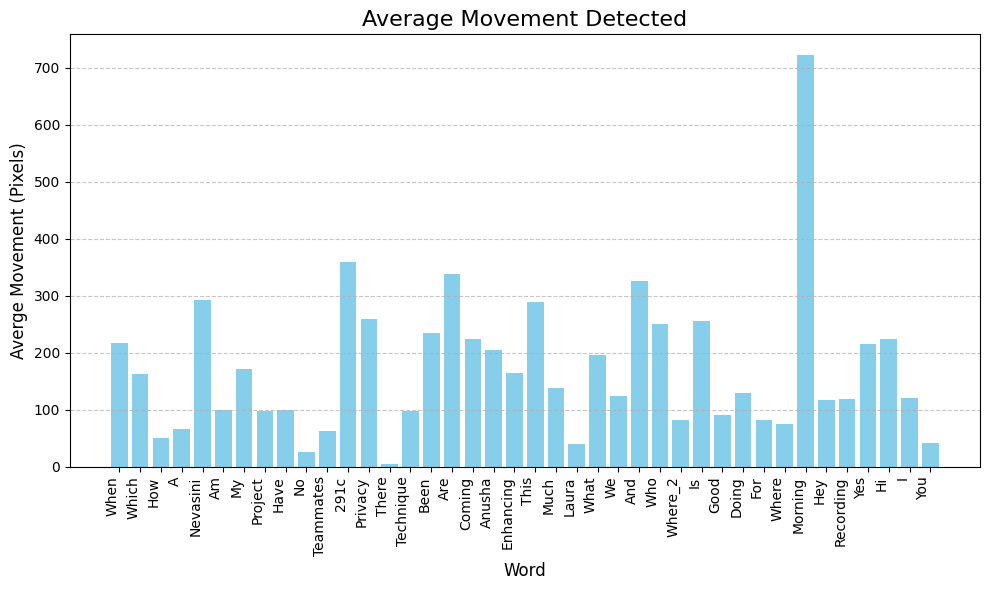

In [28]:
plot_simple_bar_graph(
    motion_avg,
    title='Average Movement Detected', 
    x_label='Word', 
    y_label='Averge Movement (Pixels)',
)

In [7]:
# count of packets per word
PACKET_FILES = './total-packets/'
packet_files = os.listdir(PACKET_FILES)
packet_counts = {}

for p in packet_files:
    file = PACKET_FILES+p
    name = p.split(sub1)[0]  # Finding the index of the substring 1
    name = name.split(sub2)[0]  # Finding the index of the substring 2

    cap = pyshark.FileCapture(file)
    count = 0
    # for packet in cap:
    #     count += 1

    # if name not in packet_counts:
    #     packet_counts[name] = [count]
    # else:
    #     packet_counts[name].append(count)


    try:
        async for packet in cap: # Changed to async for
            count += 1
            # Assuming 'name' is some attribute you're looking for, e.g., packet.ip.src
            # Replace 'name' with the actual attribute you want to count
            # if hasattr(packet, 'ip') and hasattr(packet.ip, 'src'):
            #     name = packet.ip.src # Example: using source IP as 'name'
            # elif hasattr(packet, 'eth') and hasattr(packet.eth, 'src'):
            #      name = packet.eth.src # Fallback: using Ethernet source as 'name'
            # else:
            #     name = "Unknown" # Or handle as per your requirement

            if name not in packet_counts:
                packet_counts[name] = 0
            packet_counts[name] += 1
    finally:
        # Ensure the capture process is closed, even if an error occurs
        await cap.close()

packet_averages = {}
for k in packet_counts.keys():
    packet_averages[k] = np.mean(packet_counts[k])

RuntimeError: This event loop is already running

In [ ]:
plot_simple_bar_graph(
    packet_counts,
    title='Average Packet Counts Per Word',
    x_label='Word',
    y_label='Average Num of Packets'
)